### 引入库

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

#### 参数设置

In [2]:
n_epochs = 5          #学习次数，根据拟合程度调整。太大过拟合；太小欠拟合
batch_size_train = 100 #训练时的批次大小，根据拟合程度和硬件性能调整。太大过拟合，占用内存大，训练速度慢；太小易受噪声影响，易陷入局部最小值
batch_size_test = 50   #测试时的批次大小，调整没啥影响，一般和训练批次大小相似
learning_rate = 1e-3   #学习率，控制参数调整幅度。太大不稳定，可能跳过全局最小值；太小收敛速度慢，易陷入局部最小值
momentum = 0.5         #动量，减少陷入局部最小值情况。太大不稳定，可能跳过全局最小值；太小收敛速度慢，易陷入局部最小值。SGD用的，Adam用不到
log_interval = 100     #日志输出间隔，控制输出训练信息频率

random_seed = 1 #随机种子，用于复现结果
torch.manual_seed(random_seed) #设置随机种子

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
#使用确定性算法确保结果可复现

# 检查是否有可用的GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

#### 导入MNIST数据集  
自动下载到根目录下的 ./data/ 路径

数据集保存在 train_loader 和 test_loader 中
每张图片的灰度值 tensor 位于 train_loader.dataset.data 和 train_loader.dataset.data 中 
数量分别为 6w 和 1w

每张图片的 tensor 
dtype=torch.uint8
torch.Size([28, 28])

In [3]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', #数据集本地存储路径，没有则创建
                               train=True, #加载训练集
                               download=True, #如果本地不存在数据集，会下载数据集
                               transform=torchvision.transforms.ToTensor(), #将图像转换为PyTorch张量                          
                               ),
    batch_size=batch_size_train, #设置批次大小
    shuffle=True,  #每次打乱
    )   

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/',
                               train=False,
                               download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   ]),
                               ),
    batch_size=batch_size_test,
    shuffle=True,
    )

#### 定义卷积网络
输入 tensor 大小：[1, 28, 28]->  
conv1 -> [8, 24, 24] ->  
max_pool2d -> [8, 12, 12] ->  
conv2 -> [64, 8, 8] ->  
max_pool2d -> [64, 4, 4] ->  
view -> [1024] ->  
fc1 -> [256] ->  
relu -> [256] ->  
fc2 -> [10] (10分类)

In [4]:
#定义神经网络
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() #初始化方法
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5) #卷积层1：输入通道数，输出通道数，kernel_size表示卷积核的大小
        self.conv2 = nn.Conv2d(8, 64, kernel_size=5) #卷积层2
        self.fc1 = nn.Linear(1024, 256) #全连接层类1:输入特征数，输出特征数
        self.fc2 = nn.Linear(256, 10) #全连接层类2
        self.conv_drop = nn.Dropout2d() #二维Dropout层，正则化，防止过拟合
        
    def forward(self, x):     #前向传播方法
        x = F.relu(F.max_pool2d(self.conv1(x), 2))         
        x = F.relu(F.max_pool2d(self.conv_drop(self.conv2(x)), 2))
        x = x.view(-1, 1024)                      #将二维张量x展平为一维张量。使用-1可以根据其他维度推断出一个维度的大小，1024是展平后张量的大小。
        x = F.relu(self.fc1(x))                  #对展平后的张量应用全连接层1，对全连接层1的结果应用ReLU激活函数 
        x = self.fc2(x)                          #对张量x应用全连接层2
        return F.log_softmax(x, dim=1) #对第二个全连接层的输出应用对数softmax函数，获取对数概率；dim=1指定应在列上应用，该维度表示不同的类别

network = Net().to(device)

#### 定义优化器
这里使用的优化器是Adam  
之前用的 learning rate 是0.01，导致第一个 epoch 的 accuracy 百分之90多，然后后面掉到30多了(⊙o⊙)？

In [5]:
optimizer = optim.Adam(params = network.parameters(), lr=learning_rate)

#### 定义训练函数和测试函数

In [6]:
train_losses = [] #存储每个epoch的平均训练损失
train_counter = [] #存储每个epoch结束时的总训练步数
test_losses = [] #存储每个epoch的平均测试损失
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)] #存储每个epoch结束时的总测试步数
accuracy_counter = [] #存储每个 epoch 的准确率

#定义训练函数
def train(epoch): #传入epoch只是为了输出当前epoch
    network.train() #将神经网络设置为训练模式
    for batch_idx, (data, target) in enumerate(train_loader): #遍历训练数据集的每个小批次
        data, target = data.to(device), target.to(device) #将数据和标签移动到device上
        optimizer.zero_grad()                             #将优化器的梯度缓存清零
        output = network(data)                            #将输入数据传递给神经网络
        loss = F.nll_loss(output, target)                 #使用负对数似然损失函数计算损失
        loss.backward()                                   #反向传播,计算损失
        optimizer.step()                                  #根据梯度更新网络的参数
        if batch_idx % log_interval == 0:                 #延长日志输出间隔
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data),
                                                                           len(train_loader.dataset),
                                                                           100. * batch_idx / len(train_loader),
                                                                           loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx * batch_size_train) + ((epoch) * len(train_loader.dataset)))
            torch.save(network.state_dict(), './model.pth')       #保存当前的神经网络状态
            torch.save(optimizer.state_dict(), './optimizer.pth') #保存当前的优化器状态

def test(epoch):
    network.eval() #将神经网络设置为评估（测试）模式
    test_loss = 0  #初始化测试损失，用于计算测试集上的累积损失
    correct = 0    #初始化正确预测的样本数，用于计算准确率
    with torch.no_grad(): #上下文管理器，在该块中的操作不会影响到梯度计算
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    accuracy_counter.append(100. * correct / len(test_loader.dataset))
    print('\nEpoch  {} Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        epoch,test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))




#### 训练和输出

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.310331
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.184919
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.292612
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.119954
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.272898
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.179761

Epoch  0 Test set: Avg. loss: 0.0639, Accuracy: 9808/10000 (98.08%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.103659
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.151894
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.032523
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.092839
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.070866
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.036721

Epoch  1 Test set: Avg. loss: 0.0377, Accuracy: 9880/10000 (98.80%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.066366
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.085760
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.023624
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.158026
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.033961
Train Epoch: 2 [50000/600

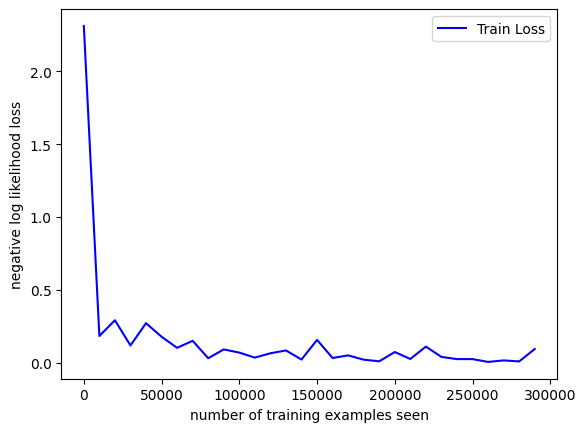

<Figure size 640x480 with 0 Axes>

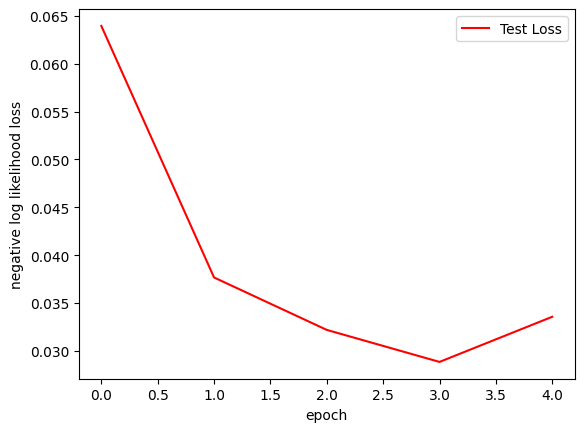

<Figure size 640x480 with 0 Axes>

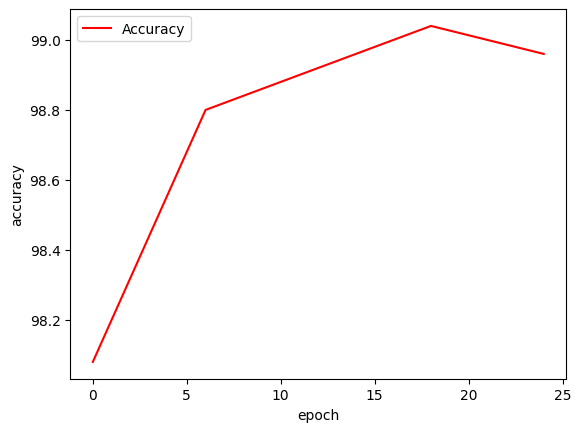

<Figure size 640x480 with 0 Axes>

In [7]:
for epoch in range(n_epochs):
    train(epoch)
    test(epoch)

# train loss
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()
fig = plt.figure()

# test loss
fig = plt.figure()
plt.plot([x / len(train_loader.dataset) for x in test_counter][:-1], test_losses, color='red')
plt.legend(['Test Loss'], loc='upper right')
plt.xlabel('epoch')
plt.ylabel('negative log likelihood loss')
plt.show()
fig = plt.figure()

# accuracy
fig = plt.figure()
plt.plot([x / len(test_loader.dataset) for x in test_counter][:-1], [x.item() for x in accuracy_counter], color='red')
plt.legend(['Accuracy'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()
fig = plt.figure()

~~总感觉随机数没设置好，每次跑出来不一样~~  
已解决该问题